In [1]:
import sys
sys.path.append('/home/dan/burkhardt/software/MELD/python/')
import meld
import scprep

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']


from scipy.spatial.distance import cosine, cdist, squareform, pdist
from sklearn import preprocessing
import seaborn as sns
import scprep
import phate
import graphtools as gt
from scipy.stats import zscore

import dbio

In [2]:
t_cell_data_uf = pd.read_csv('/data/dan/burkhardt/blitz/CROP_seq/data_from_david/data/GSE92872_CROP-seq_Jurkat_TCR.digital_expression.csv.gz', header=None, skiprows=6, index_col=0).T
sample_info_uf = pd.read_csv('/data/dan/burkhardt/blitz/CROP_seq/data_from_david/data/GSE92872_CROP-seq_Jurkat_TCR.digital_expression.csv.gz', header=None, nrows=5, index_col=0)
stim_uf = sample_info_uf.loc['condition'].values

t_cell_data_uf.index = pd.MultiIndex.from_arrays([np.arange(t_cell_data_uf.shape[0]), stim_uf], names=['idx', 'condition'])

(-2219.9500000000003, 59972.95)


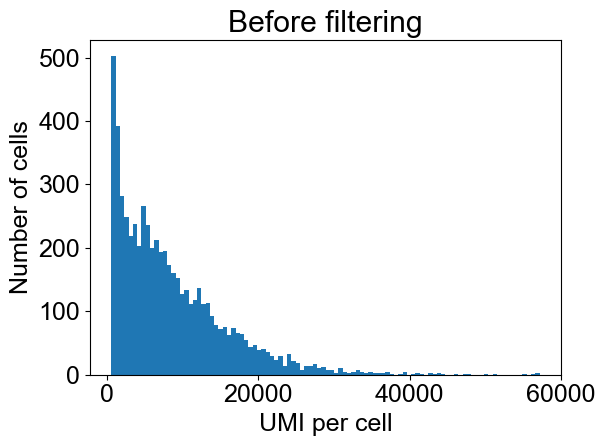

In [3]:
scprep.plot.plot_library_size(t_cell_data_uf, log=False)
plt.xlabel('UMI per cell')
plt.ylabel('Number of cells')
plt.title('Before filtering')
print(plt.xlim())
plt.tight_layout()
plt.savefig('/home/dan/burkhardt/blog/figs/libsize_example_normal.png', dpi=300, transparent=True)
plt.savefig('/home/dan/docs/websites/ksl_blog/posts/img/libsize_example_normal.png', dpi=300, transparent=True)

In [4]:
t_cell_data = scprep.filter.filter_library_size(t_cell_data_uf, cutoff=25000, keep_cells='below')

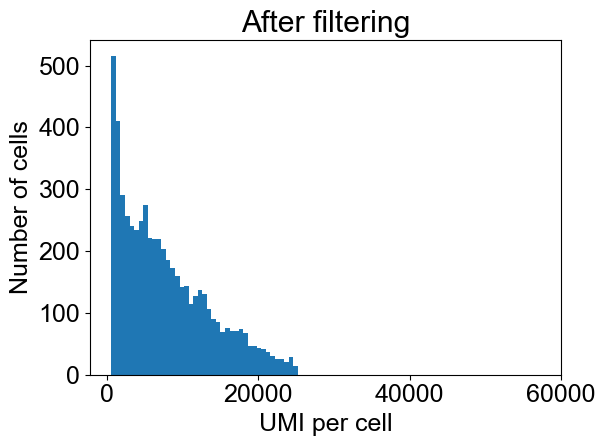

In [5]:
scprep.plot.plot_library_size(t_cell_data, range=(0,60000), log=False)
plt.xlabel('UMI per cell')
plt.ylabel('Number of cells')
plt.title('After filtering')

plt.xlim(-2219.9500000000003, 59972.95)
plt.tight_layout()
plt.savefig('/home/dan/burkhardt/blog/figs/libsize_example_filtered.png', dpi=300, transparent=True)
plt.savefig('/home/dan/docs/websites/ksl_blog/posts/img/libsize_example_filtered.png', dpi=300, transparent=True)

#### comparison of three

In [ ]:
#This wrapper creates a pandas dataframe from the genes, barcodes & expression tsv files from GEO
data_unfilt = scprep.io.load_10X('/home/valerie/data/CellRanger_out/Z-brain-4dpf/outs/filtered_gene_bc_matrices/danrer_protein_coding_GRCz10/', sparse=False)
g_gene_names = data_unfilt.columns.values

libsize = data_unfilt.sum(axis=1)
n_genes = (data_unfilt > 1).sum(axis=1)
n_cells = np.sum(data_unfilt > 0, axis=0)

data = data_unfilt.values[:,n_cells >= 5]
g_gene_names = g_gene_names[n_cells >= 5]
data_ln = phate.io.library_size_normalize(data)

In [7]:
zh_expression = pd.read_csv('/home/dan/data/burkhardt/habenular-zebrafish/GSM2818521_larva_counts_matrix.txt.gz', delimiter=' ').T

#This wrapper creates a pandas dataframe from the genes, barcodes & expression tsv files from GEO
MZoep = scprep.io.load_10X('/home/dan/data/burkhardt/zebrafish/schier_developmental_trajectories/10xMZoep6S')
gene_names = MZoep.columns.values

WT = scprep.io.load_10X('/home/dan/data/burkhardt/zebrafish/schier_developmental_trajectories/10xWT6S/')

data_MZ = pd.concat([MZoep, WT])
samples = np.hstack([np.ones(2200), np.ones(3000) * 2])
del MZoep, WT

x1 = np.sum(zh_expression, axis=1)
y1 = np.sum(zh_expression > 0, axis=1)

x2 = np.sum(data_unfilt,axis=1)
y2 = np.sum(data_unfilt > 0,axis=1)

x3 = np.sum(data_MZ, axis=1)
y3 = np.sum(data_MZ > 0,axis=1)

/home/dan/.local/lib/python3.7/site-packages/scprep/io.py:414: RuntimeWarning: Duplicate gene names detected! Forcing `gene_labels='id'`. Alternatively, try `gene_labels='both'`, `allow_duplicates=True`, or load the matrix with `sparse=False`
  " with `sparse=False`", RuntimeWarning)


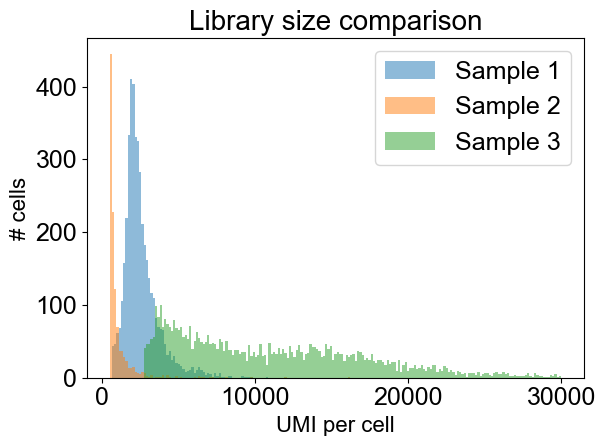

In [23]:
b = np.linspace(500,30000, 200)
plt.hist(x1, bins=b, label='Sample 1', alpha=0.5)

plt.hist(x2, bins=b, label='Sample 2', alpha=0.5)
plt.hist(x3, bins=b, label='Sample 3', alpha=0.5)
plt.legend()
plt.title('Library size comparison', fontsize=20)
plt.xlabel('UMI per cell', fontsize=16)
plt.ylabel('# cells', fontsize=16)
plt.tight_layout()
plt.savefig('../figs/libsize_comparison.png', dpi=300, transparent=True)
plt.savefig('/home/dan/docs/websites/ksl_blog/posts/img/libsize_example_flibsize_comparison.png', dpi=300, transparent=True)

#### Filtering Rare Genes

In [6]:
genes_per_cell = np.sum(t_cell_data > 0, axis=0)

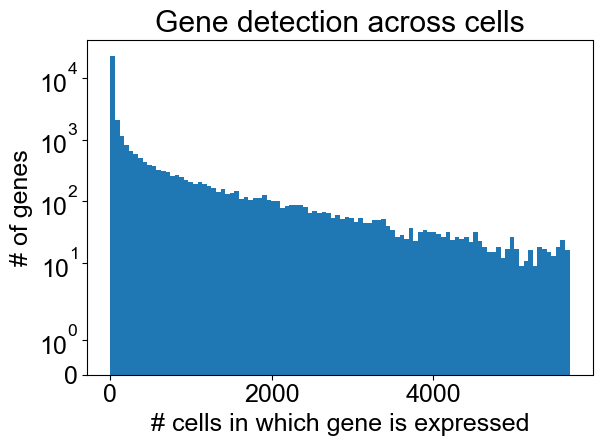

In [7]:
h = plt.hist(genes_per_cell, bins=100)
plt.xlabel('# cells in which gene is expressed')
plt.ylabel('# of genes')
plt.yscale('symlog')
plt.title('Gene detection across cells')
plt.tight_layout()
plt.savefig('../figs/gene_detection.png', dpi=300, transparent=True)
plt.savefig('/home/dan/docs/websites/ksl_blog/posts/img/gene_detection.png', dpi=300, transparent=True)

In [8]:
t_cell_data = scprep.filter.remove_rare_genes(t_cell_data, min_cells=10)

In [9]:
data_ln, libsize = scprep.normalize.library_size_normalize(t_cell_data, return_library_size=True)

In [10]:
mitochondrial_gene_list = np.array([g.startswith('MT-') for g in data_ln.columns])

mito_exp = data_ln.loc[:,mitochondrial_gene_list].mean(axis=1)

data_ln = scprep.filter.filter_values(data_ln, mito_exp, percentile=95, keep_cells='below')
idx = mito_exp < np.percentile(mito_exp, 95)
libsize = libsize.loc[idx]
data_ln.head()

,,A1BG,A1BG-AS1,AAAS,AACS,AADAT,AAED1,AAGAB,AAK1,AAMDC,AAMP,...,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3,bP-21201H5.1,bP-21264C1.2,bP-2189O9.2,chr22-38_28785274-29006793.1
idx,condition,,,,,,,,,,,,,,,,,,,,,
0,stimulated,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,stimulated,0.0,0.0,0.000000,0.0,0.000000,2.024726,0.0,4.049452,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,stimulated,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,stimulated,0.0,0.0,2.624341,0.0,0.000000,0.000000,0.0,0.000000,0.0,2.624341,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,stimulated,0.0,0.0,0.000000,0.0,0.462402,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


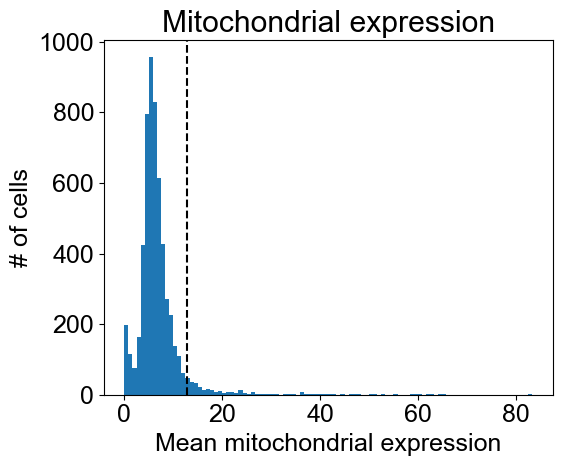

In [80]:
fig, ax = plt.subplots(1, figsize=(6,5))

ax.hist(mito_exp, bins=100)
ax.axvline(np.percentile(mito_exp, 95), color='k', linestyle='--')
ax.set_xlabel('Mean mitochondrial expression')
ax.set_ylabel('# of cells')
ax.set_title('Mitochondrial expression')

fig.tight_layout()

fig.savefig('../figs/mito_expression.png', dpi=300, transparent=True)
fig.savefig('/home/dan/docs/websites/ksl_blog/posts/img/mito_expression.png', dpi=300, transparent=True)

In [112]:
d = np.genfromtxt('/home/dan/burkhardt/meld/CROP_seq/OP_seq//files/signature_genes.txt', dtype=str)


In [11]:
from scipy import stats

In [12]:
data_zs = stats.zscore(data_ln, axis=0)

In [18]:
import sys
sys.setrecursionlimit(10000)

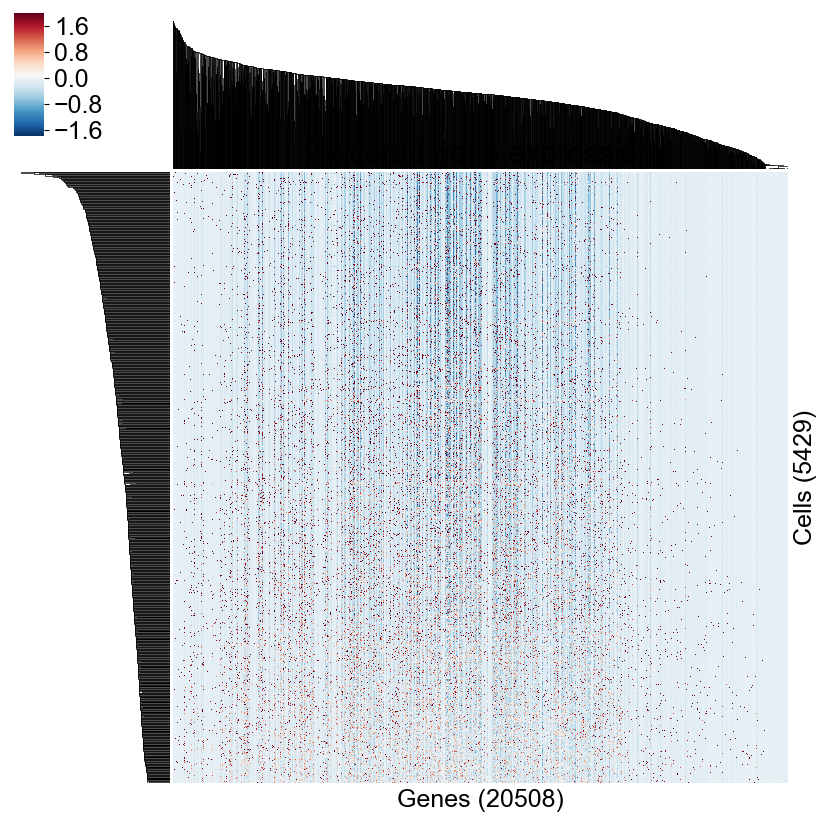

In [24]:
cg = sns.clustermap(data_zs[:1000,:2000], vmax=2, cmap='RdBu_r')

cg.ax_heatmap.set_yticks([])
cg.ax_heatmap.set_xticks([])

cg.ax_heatmap.set_xlabel('Genes ({})'.format(data_zs.shape[1]))
cg.ax_heatmap.set_ylabel('Cells ({})'.format(data_zs.shape[0]))

cg.ax_heatmap.set_title('Z-scored gene expression')

cg.savefig('../figs/datlinger_heatmap.png', transparent=True, dpi=300)
cg.savefig('/home/dan/docs/websites/ksl_academic/static/img/how_to_single_cell/datlinger_heatmap.png', transparent=True, dpi=300)

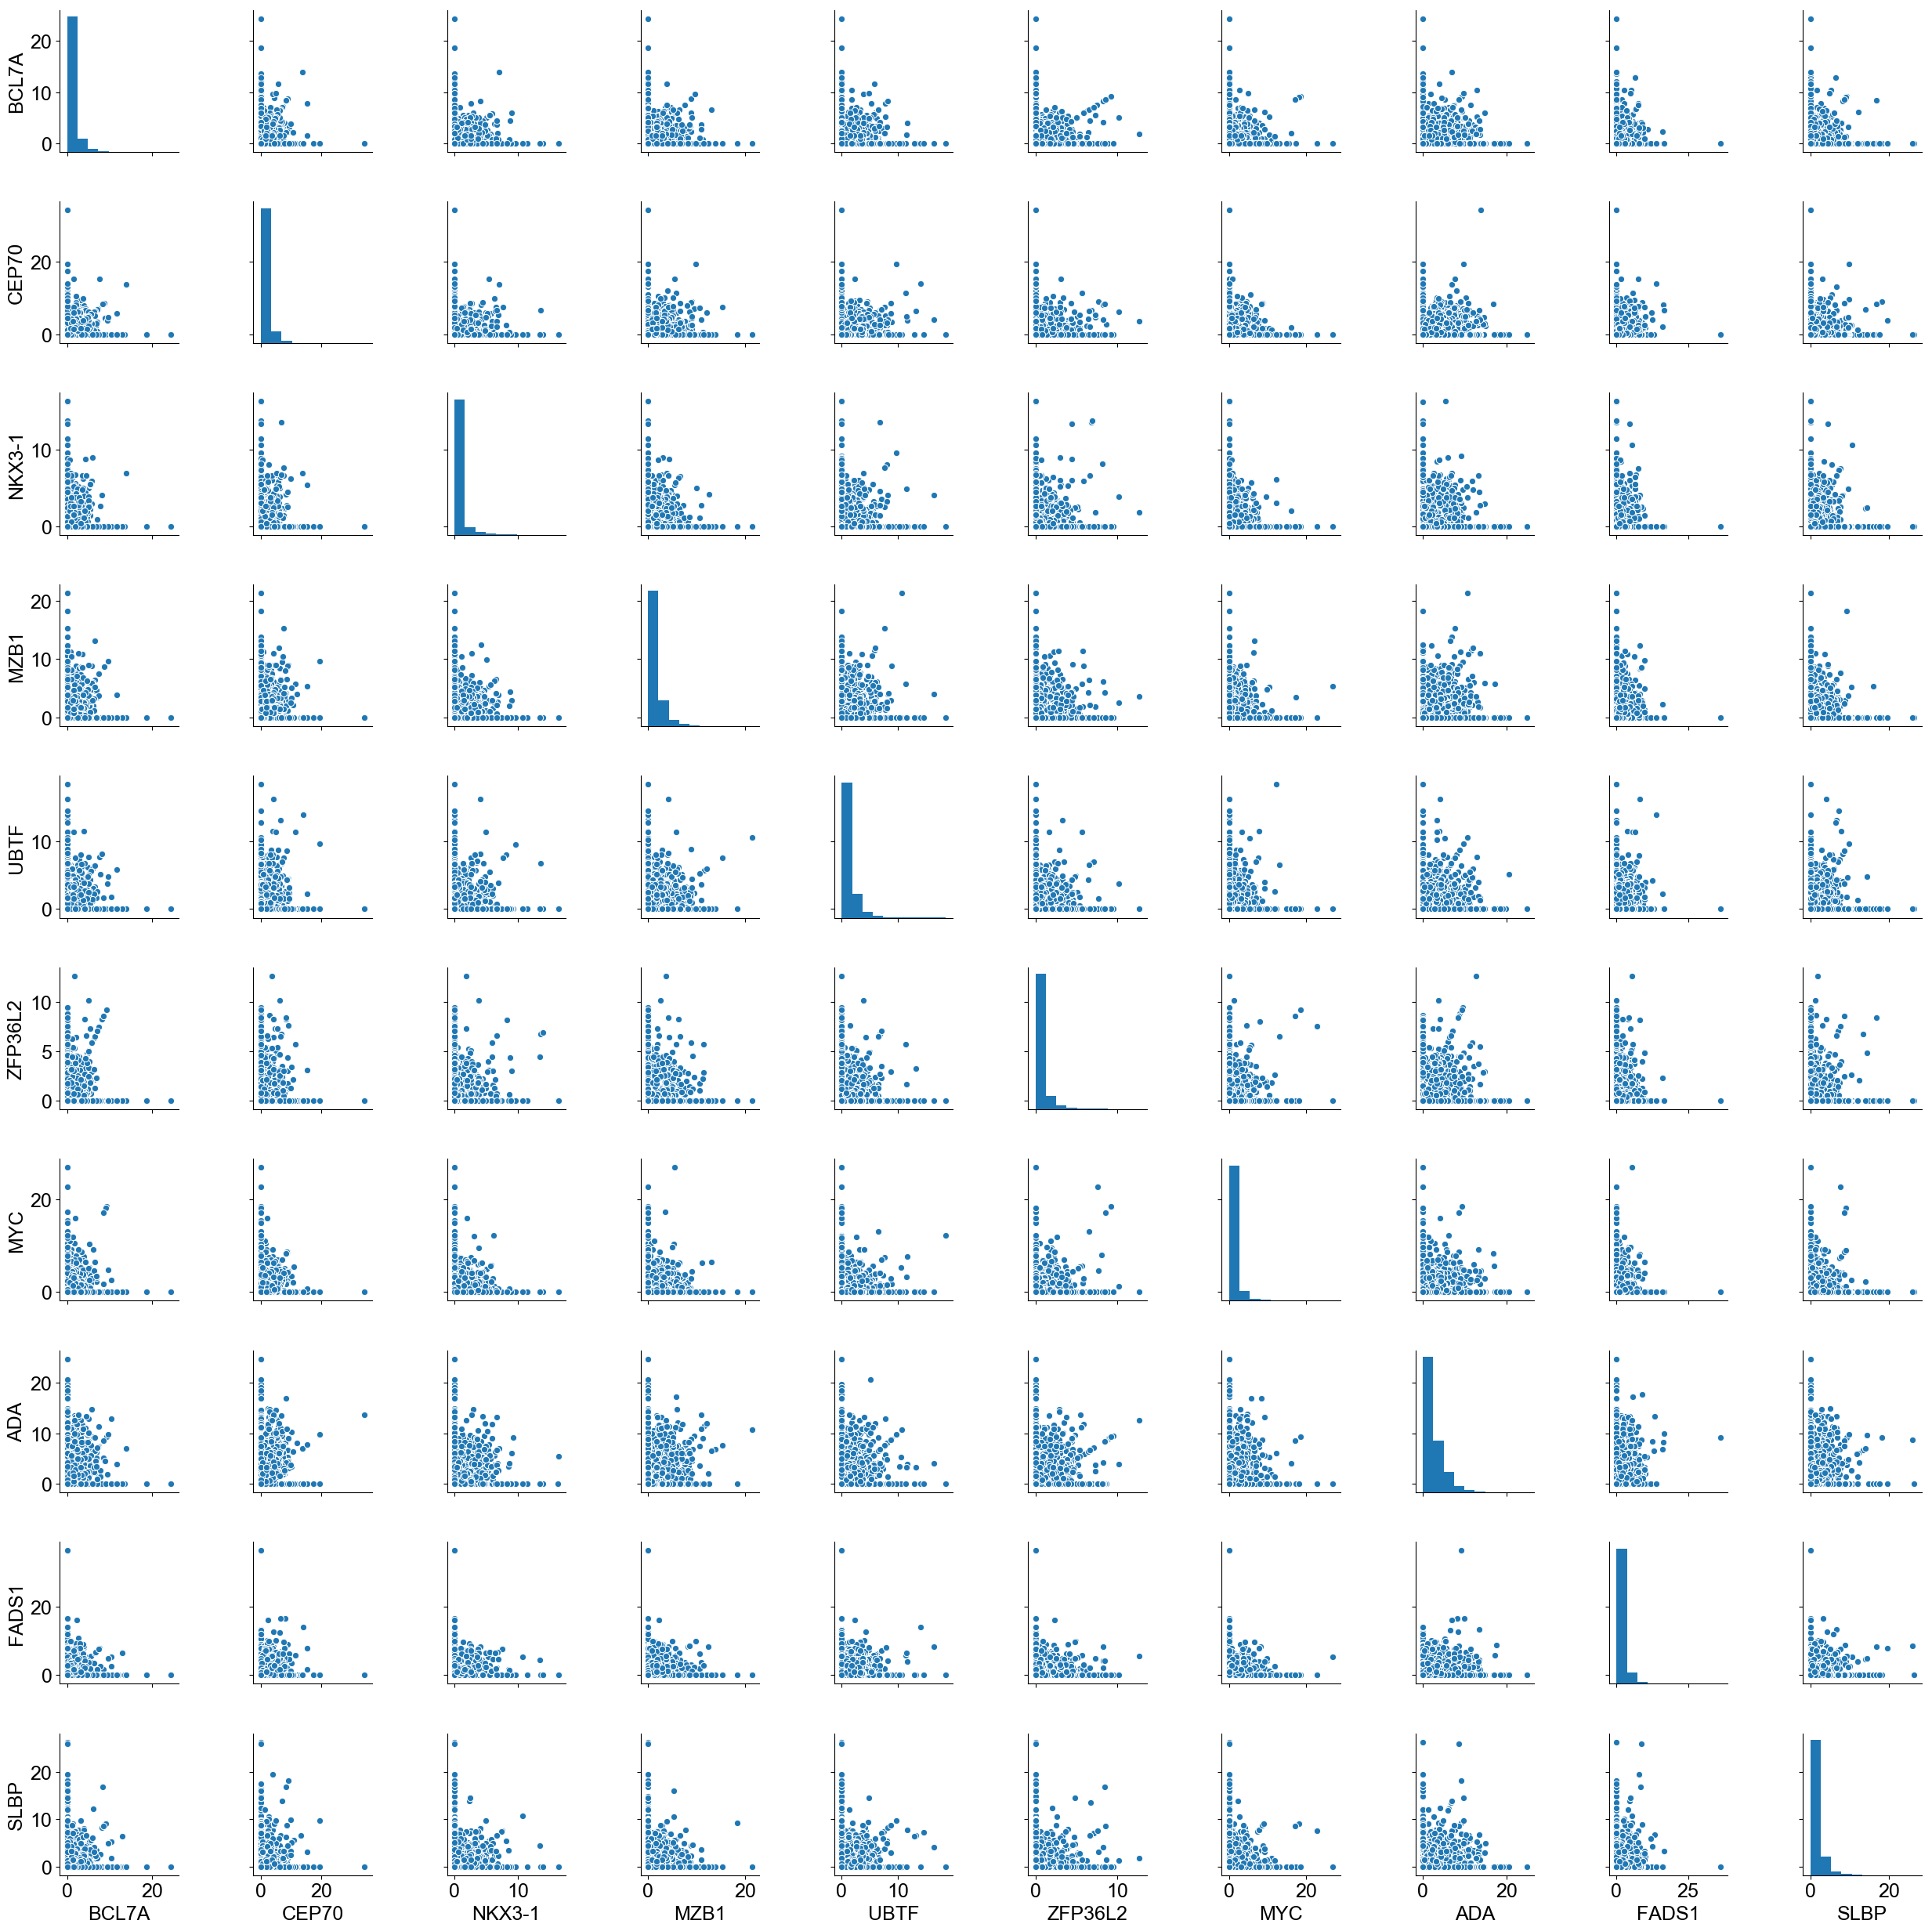

In [116]:
sns.pairplot(data_ln.loc[:,d[:10]])
plt.tight_layout()
plt.savefig('/home/dan/burkhardt/blog/figs/datlinger_pairplot.png', dpi=300, transparent=True)
plt.savefig('/home/dan/docs/websites/ksl_blog/posts/img/datlinger_pairplot.png', dpi=300, transparent=True)

In [223]:
data_sq = scprep.transform.sqrt(data_ln)

#### PCA

In [224]:
tcell_data_pcs = scprep.reduce.pca(data_sq, n_pca=100)

In [119]:
from sklearn.decomposition import PCA

In [259]:
pc_op = PCA()
data_pcs = pc_op.fit_transform(scprep.transform.sqrt(data_ln))

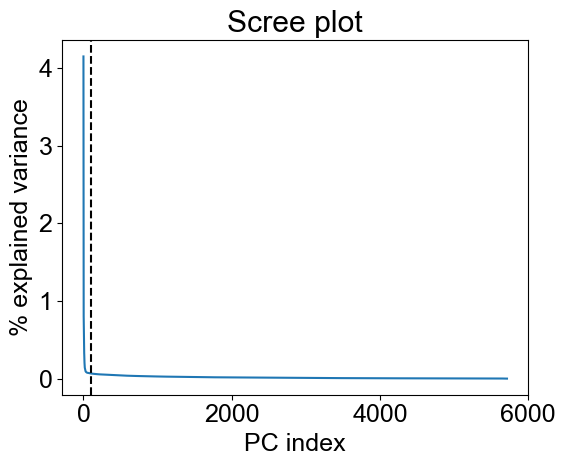

In [134]:
fig, ax = plt.subplots(1, figsize=(6,5))

ax.plot(pc_op.explained_variance_/pc_op.explained_variance_.sum() * 100)
ax.axvline(100, c='k', linestyle='--')
ax.set_xlabel('PC index')
ax.set_ylabel('% explained variance')
ax.set_title('Scree plot')

fig.tight_layout()

plt.savefig('/home/dan/burkhardt/blog/figs/datlinger_screeplot.png', dpi=300, transparent=True)
plt.savefig('/home/dan/docs/websites/ksl_blog/krishnaswamy_blog/static/img/how_to_single_cell/datlinger_screeplot.png', dpi=300, transparent=True)

In [132]:
pc_op.explained_variance_.cumsum()[100]/pc_op.explained_variance_.sum()

0.20333394141561936

In [148]:
pc_op.explained_variance_.cumsum()[500]/pc_op.explained_variance_.sum()

0.40575358959743907

In [252]:
plt.plot(tcell_data_pcs[:,101])
plt.xlabel('Cell index')
plt.ylabel('PC 101 Magnitude')

IndexError: index 101 is out of bounds for axis 1 with size 100

In [240]:
stim = data_ln.index.get_level_values('condition')

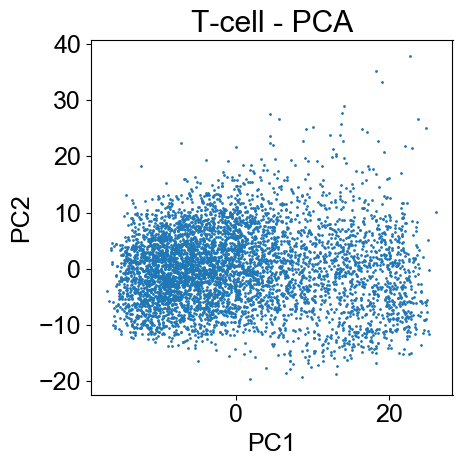

In [267]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.scatter(data_pcs[:,0], data_pcs[:,1], s=1)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('T-cell - PCA')

fig.tight_layout()

fig.savefig('/home/dan/burkhardt/blog/figs/datlinger.PCA.nocolor.png', dpi=300, transparent=True)
fig.savefig('/home/dan/docs/websites/ksl_blog/krishnaswamy_blog/static/img/how_to_single_cell/datlinger.PCA.nocolor.png', dpi=300, transparent=True)

In [284]:
stim = data_ln.index.get_level_values('condition')
condition_cdict = {'stimulated':'#1a3263',
                   'unstimulated':'#f5564e'}
condition_cvec  = np.array([condition_cdict[cond] for cond in stim])

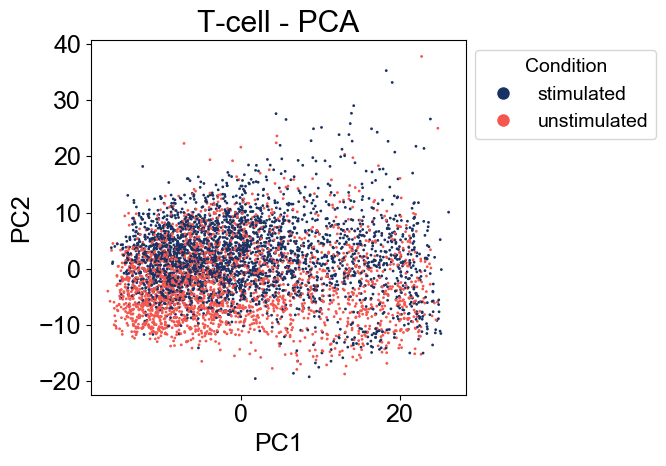

In [294]:
fig, ax = plt.subplots(1, figsize=(7,5))

r = dbio.shuffle_idx(data_pcs)

ax.scatter(data_pcs[:,0][r], data_pcs[:,1][r], s=1, c=condition_cvec[r])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('T-cell - PCA')

dbio.generate_legend(condition_cdict, ax, title='Condition', bbox_to_anchor=(1,1))

fig.tight_layout()


fig.savefig('/home/dan/burkhardt/blog/figs/datlinger.PCA.condition.png', dpi=300, transparent=True)
fig.savefig('/home/dan/docs/websites/ksl_blog/krishnaswamy_blog/static/img/how_to_single_cell/datlinger.PCA.condition.png', dpi=300, transparent=True)

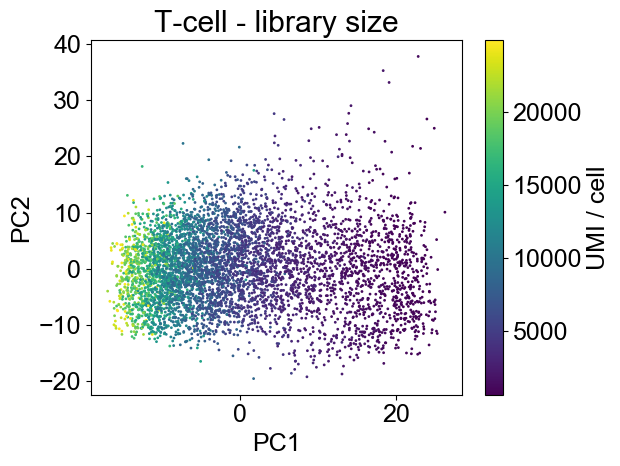

In [290]:
fig, ax = plt.subplots(1, figsize=(6.5,5))

sc = ax.scatter(data_pcs[:,0], data_pcs[:,1], s=1, c=libsize)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('T-cell - library size')

cbar = fig.colorbar(sc, ax=ax)
cbar.ax.set_ylabel('UMI / cell')

fig.tight_layout()


fig.savefig('/home/dan/burkhardt/blog/figs/datlinger.PCA.libsize.png', dpi=300, transparent=True)
fig.savefig('/home/dan/docs/websites/ksl_blog/krishnaswamy_blog/static/img/how_to_single_cell/datlinger.PCA.libsize.png', dpi=300, transparent=True)

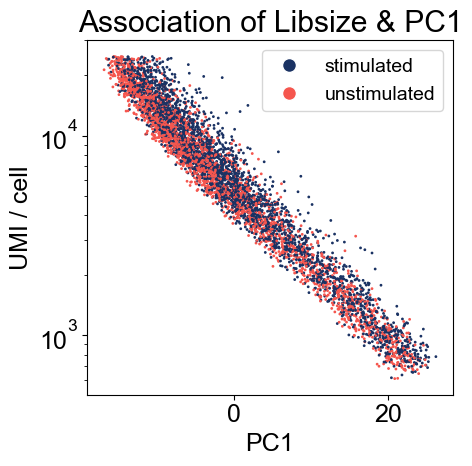

In [372]:
fig, ax = plt.subplots(1, figsize=(5,5))

r = dbio.shuffle_idx(data_pcs)
ax.scatter(data_pcs[:,0][r], libsize[r], c=condition_cvec[r], s=1)
ax.set_yscale('log')
ax.set_ylabel('UMI / cell')
ax.set_xlabel('PC1')
ax.set_title('Association of Libsize & PC1')

fig.tight_layout()

dbio.generate_legend(condition_cdict, ax)

fig.savefig('/home/dan/burkhardt/blog/figs/datlinger.PCA.pc1_vs_libsize.png', dpi=300, transparent=True)
fig.savefig('/home/dan/docs/websites/ksl_blog/krishnaswamy_blog/static/img/how_to_single_cell/datlinger.PCA.pc1_vs_libsize.png', dpi=300, transparent=True)

In [382]:
scprep.utils.get_gene_set(data_ln, starts_with='MT-')

Index(['MT-ATP6', 'MT-ATP8', 'MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-CYB', 'MT-ND1',
       'MT-ND2', 'MT-ND3', 'MT-ND4', 'MT-ND4L', 'MT-ND5', 'MT-ND6', 'MT-RNR1',
       'MT-RNR2', 'MT-TA', 'MT-TC', 'MT-TD', 'MT-TE', 'MT-TF', 'MT-TG',
       'MT-TH', 'MT-TI', 'MT-TL1', 'MT-TL2', 'MT-TM', 'MT-TP', 'MT-TQ',
       'MT-TR', 'MT-TS1', 'MT-TS2', 'MT-TT', 'MT-TV', 'MT-TW', 'MT-TY'],
      dtype='object', name=0)

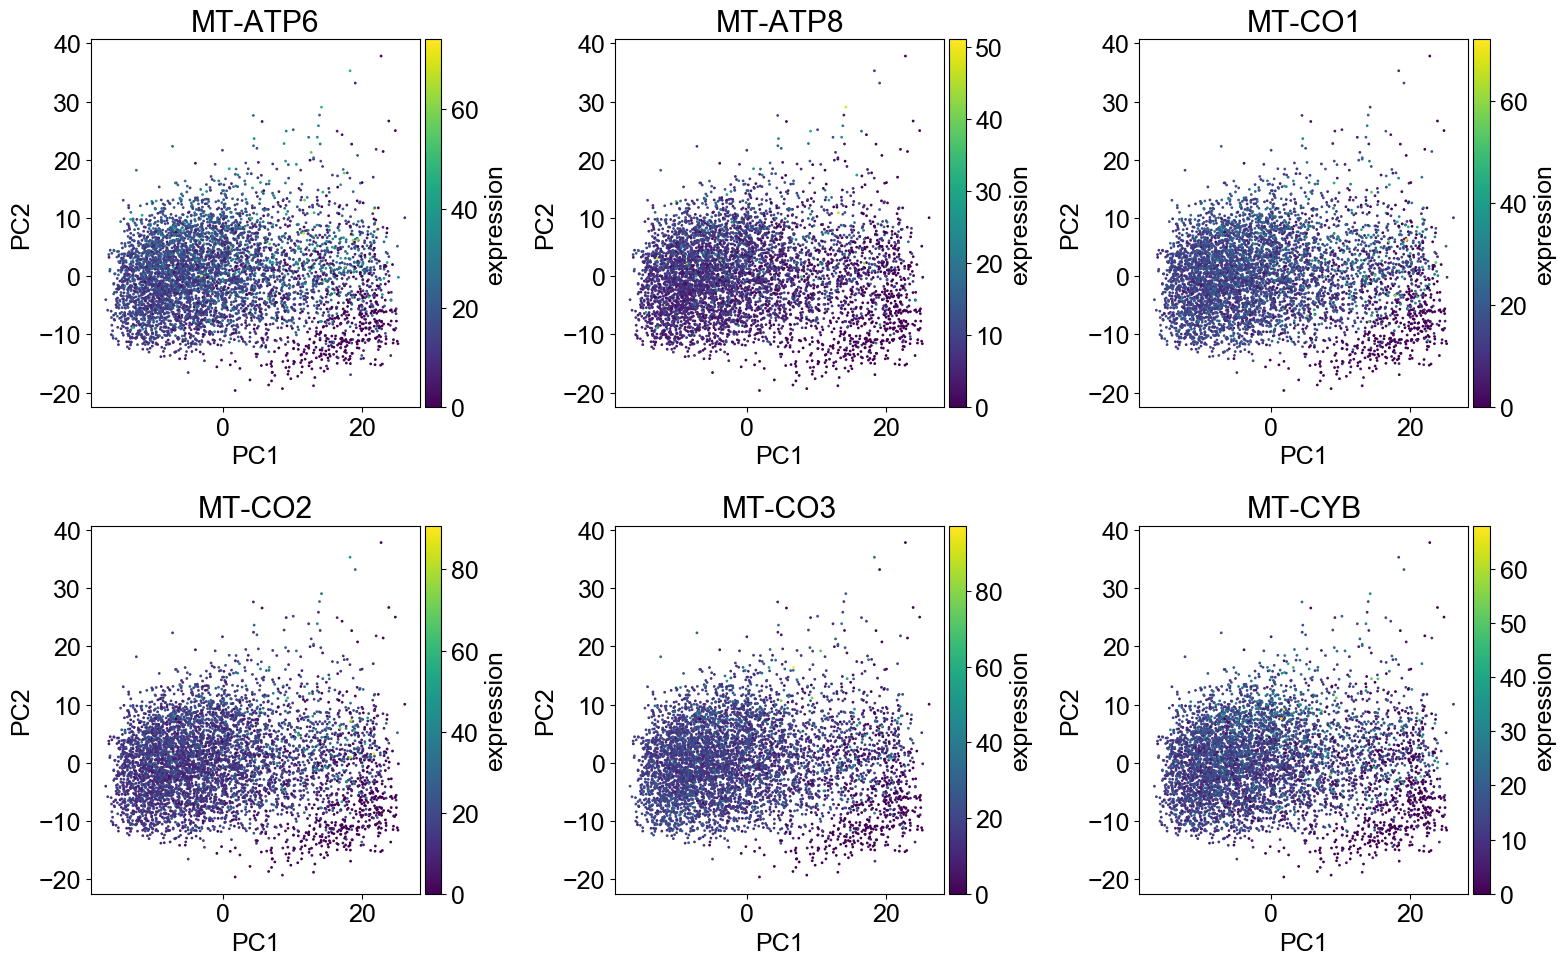

In [389]:
fig, axes = plt.subplots(2,3, figsize=(16,10))
axes = axes.flatten()

mito_genes = scprep.utils.get_gene_set(data_ln, starts_with='MT-')

for i, ax in enumerate(axes):
    exp = data_ln[mito_genes[i]]
    sc = ax.scatter(data_pcs[:,0], data_pcs[:,1], s=1, c=exp)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title(mito_genes[i])
    
    cbar = fig.colorbar(sc, cax=dbio.get_cbar_ax(ax))
    cbar.ax.set_ylabel('expression')

fig.tight_layout()

fig.savefig('/home/dan/burkhardt/blog/figs/datlinger.PCA.mito_exp.png', dpi=300, transparent=True)
fig.savefig('/home/dan/docs/websites/ksl_blog/krishnaswamy_blog/static/img/how_to_single_cell/datlinger.PCA.mito_exp.png', dpi=300, transparent=True)

AttributeError: module 'scprep.plot' has no attribute 'scatter2d'

#### Retinal biopolar

In [326]:
import os
import scprep
import numpy as np
import pandas as pd
import h5py
import phate

data_dir = "/data/scottgigante/datasets/shekhar_retinal_bipolar"
clusters = pd.read_csv(
    os.path.join(data_dir, "retina_clusters.tsv"), sep="\t", index_col=0)
cells = pd.read_csv(
    os.path.join(data_dir, "retina_cells.csv"),
    header=None).values.reshape(-1)[:-1]  # missing one cell
with h5py.File(os.path.join(data_dir, "retina_data.mat"), 'r') as f:
    retinal_bipolar_data = pd.DataFrame(
        np.array(f['data']).T,
        index=cells)

clusters = pd.merge(data, clusters, how='left',
                    left_index=True, right_index=True).iloc[:, -1]
cluster_assign = {
    '1': 'Rod BC',
    '2': 'Muller Glia',
    '7': 'BC1A',
    '9': 'BC1B',
    '10': 'BC2',
    '12': 'BC3A',
    '8': 'BC3B',
    '14': 'BC4',
    '3':  'BC5A',
    '13': 'BC5B',
    '6': 'BC5C',
    '11': 'BC5D',
    '5': 'BC6',
    '4': 'BC7',
    '15_1': 'BC8/9_1',
    '15_2': 'BC8/9_2',
    '16_1':  'Amacrine_1',
    '16_2':  'Amacrine_2',
    '20': 'Rod PR',
    '22': 'Cone PR',
}
celltypes = np.full_like(clusters, "NA")
for label, celltype in cluster_assign.items():
    celltypes = np.where(clusters == label, celltype, celltypes)

In [338]:
retinal_bipolar_data = retinal_bipolar_data[celltypes != 'NA']
celltypes_fil = celltypes[celltypes != 'NA']



In [340]:
libnorm_retinal_bipolar_data = scprep.normalize.library_size_normalize(retinal_bipolar_data)
sqrt_retinal_bipolar_data = scprep.transform.sqrt(libnorm_retinal_bipolar_data)


rtbp_pcs = PCA(2).fit_transform(sqrt_retinal_bipolar_data)

In [348]:
rtbp_samples = np.array([bc.split('_')[0] for bc in retinal_bipolar_data.index])
rtbp_cdict = {ct:sns.color_palette('cubehelix', len(np.unique(rtbp_samples)))[i] for i, ct in enumerate(np.unique(rtbp_samples))}
rtbp_cvec  = np.array([rtbp_cdict[ct] for ct in rtbp_samples])


In [353]:
rtbp_cdict = {
 'Rep1': (0.10231025194333628, 0.13952898866828906, 0.2560120319409181),
 'Rep2': (0.10594361078604106, 0.3809739011595331, 0.27015111282899046),
 'Rep3': (0.4106130272672762, 0.48044780541672255, 0.1891154277778484),
 'Rep4': (0.7829183382530567, 0.48158303462490826, 0.48672451968362596),
 'Rep5': (0.8046168329276406, 0.6365733569301846, 0.8796578402926125),
 'Rep6': (0.7775608374378459, 0.8840392521212448, 0.9452007992345052)}

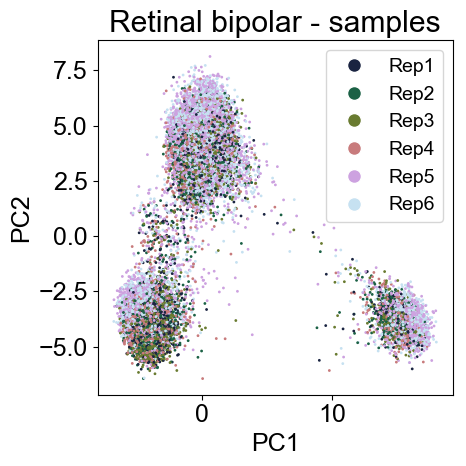

In [356]:
fig, ax = plt.subplots(1, figsize=(5,5))

r = dbio.shuffle_idx(rtbp_pcs)
ax.scatter(rtbp_pcs[:,0][r], rtbp_pcs[:, 1][r], c=rtbp_cvec[r], s=1)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

ax.set_title('Retinal bipolar - samples')

dbio.generate_legend(rtbp_cdict, ax)

fig.tight_layout()
fig.savefig('/home/dan/burkhardt/blog/figs/retinal_bipolar.PCA.samples.png', dpi=300, transparent=True)
fig.savefig('/home/dan/docs/websites/ksl_blog/krishnaswamy_blog/static/img/how_to_single_cell/retinal_bipolar.PCA.samples.png', dpi=300, transparent=True)

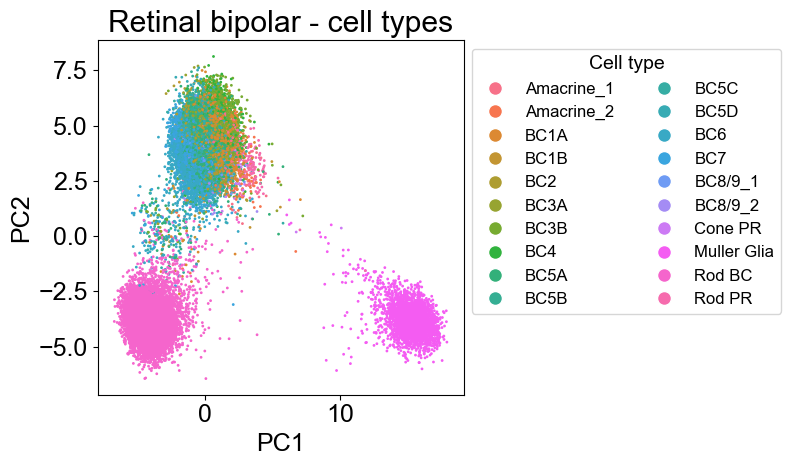

In [364]:
fig, ax = plt.subplots(1, figsize=(8.25,5))

celltype_cdict = {ct:sns.husl_palette(len(np.unique(celltypes_fil)))[i] for i, ct in enumerate(np.unique(celltypes_fil))}
celltype_cvec  = np.array([celltype_cdict[ct] for ct in celltypes_fil])

r = dbio.shuffle_idx(rtbp_pcs)
ax.scatter(rtbp_pcs[:,0][r], rtbp_pcs[:, 1][r], c=celltype_cvec[r], s=1)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

ax.set_title('Retinal bipolar - cell types')


dbio.generate_legend(celltype_cdict, ax, ncol=2, bbox_to_anchor=(1,1), fontsize=12, title='Cell type')

fig.tight_layout()
fig.savefig('/home/dan/burkhardt/blog/figs/retinal_bipolar.PCA.cell_types.png', dpi=300, transparent=True)
fig.savefig('/home/dan/docs/websites/ksl_blog/krishnaswamy_blog/static/img/how_to_single_cell/retinal_bipolar.PCA.cell_types.png', dpi=300, transparent=True)



In [373]:
libsize = retinal_bipolar_data.sum(axis=1)

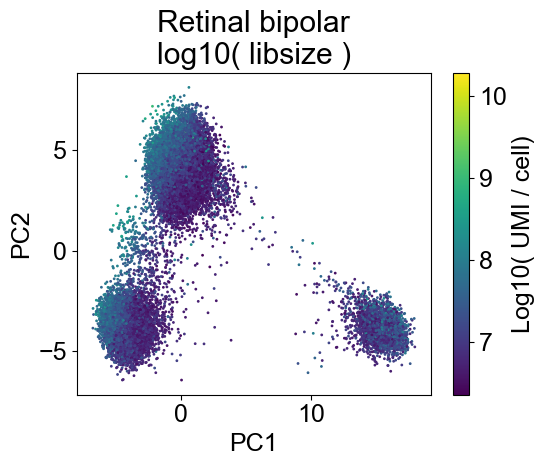

In [381]:
fig, ax = plt.subplots(1, figsize=(6,5))


r = dbio.shuffle_idx(rtbp_pcs)
sc = ax.scatter(rtbp_pcs[:,0][r], rtbp_pcs[:, 1][r], c=np.log(libsize[r]), s=1)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

ax.set_title('Retinal bipolar\nlog10( libsize )')

cbar = fig.colorbar(sc, ax=ax)
cbar.ax.set_ylabel('Log10( UMI / cell)')

#dbio.generate_legend(celltype_cdict, ax, ncol=2, bbox_to_anchor=(1,1), fontsize=12, title='Cell type')

fig.tight_layout()
fig.savefig('/home/dan/burkhardt/blog/figs/retinal_bipolar.PCA.libsize.png', dpi=300, transparent=True)
fig.savefig('/home/dan/docs/websites/ksl_blog/krishnaswamy_blog/static/img/how_to_single_cell/retinal_bipolar.PCA.libsize.png', dpi=300, transparent=True)

In [323]:
celltype_cdict = {ct:sns.husl_palette(len(np.unique(celltypes_fil)))[i] for i, ct in enumerate(np.unique(celltypes_fil))}
celltype_cvec  = np.array([celltype_cdict[ct] for ct in celltypes_fil])

Calculating PHATE...
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 16.54 seconds.
    Calculating KNN search...
    Calculated KNN search in 62.67 seconds.
    Calculating affinities...
    Calculated affinities in 0.50 seconds.
  Calculated graph and diffusion operator in 81.69 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 7.19 seconds.
    Calculating KMeans...
    Calculated KMeans in 12.67 seconds.
  Calculated landmark operator in 21.56 seconds.
  Calculating optimal t...
    Automatically selected t = 32
  Calculated optimal t in 0.57 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.24 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 6.92 seconds.
Calculated PHATE in 110.99 seconds.


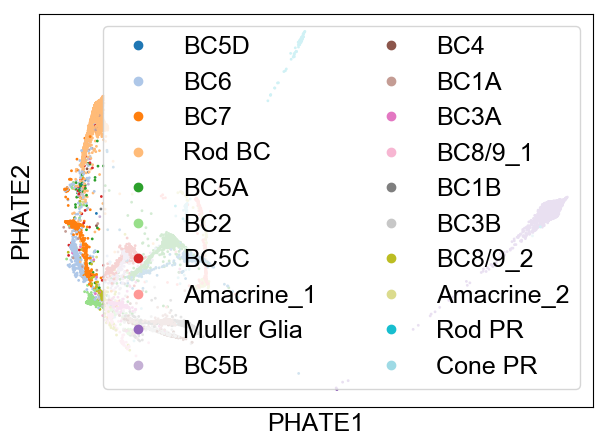

In [104]:
phate_retinal_bipolar_data = phate.PHATE().fit_transform(sqrt_retinal_bipolar_data)
phate.plot.scatter2d(phate_retinal_bipolar_data, c=celltypes_fil)

No handles with labels found to put in legend.


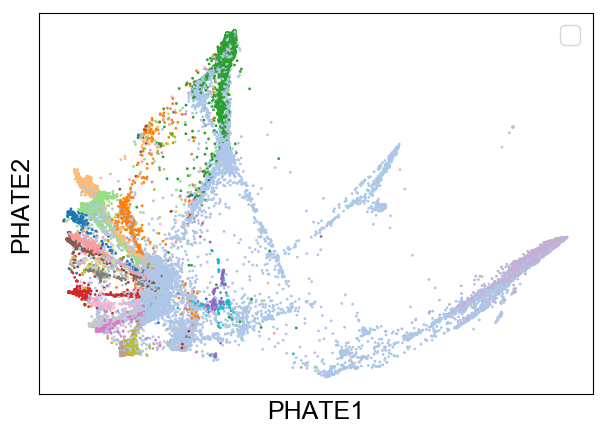

In [92]:
ax = phate.plot.scatter2d(phate_retinal_bipolar_data, c=celltypes)
plt.legend()


In [ ]:
import seaborn as sns
g = sns.pairplot(iris)